In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import keras_tuner
import chime
import tensorflow_datasets as tfds
import pandas as pd

In [2]:
%load_ext chime

Loading train, validation and test sets

In [3]:
ds = tfds.load('malaria', 
               split=('train[:60%]', 'train[60%:80%]', 'train[80%:]'), 
               shuffle_files=True,
              data_dir='./data',
               batch_size=32,
              download=False,
              as_supervised=True,
              with_info=False)
ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# First attempt

In [20]:
inputs = keras.Input(shape=(None, None, 3))
x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
x = keras.layers.Conv2D(
    filters=8,
    kernel_size=4,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation='relu')(x)
x = keras.layers.MaxPooling2D(
    pool_size=(2, 2), 
    strides=None, 
    padding="valid")(x)
x = keras.layers.Conv2D(
    filters=16,
    kernel_size=4,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation='relu')(x)
x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=32, 
                       activation="relu",
                      kernel_regularizer=None)(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [21]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 rescaling_4 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 8)     392       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 8)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 16)    2064      
                                                                 
 global_max_pooling2d_2 (Glo  (None, 16)               0         
 balMaxPooling2D)                                          

In [22]:
model.compile(optimizer='Adam',
         loss='binary_crossentropy',
         metrics=['accuracy'])

In [23]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.001,
        patience=3,
        verbose=1,
        mode="max",
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=5)
    ]

In [24]:
%%time
%%chime
history = model.fit(
    ds[0],
    epochs=20,
    verbose="auto",
    callbacks=callbacks,
    validation_split=0.0,
    validation_data=ds[1]
)

Epoch 1/20
517/517 [==============================] - 148s 286ms/step - loss: 0.6806 - accuracy: 0.5667 - val_loss: 0.6641 - val_accuracy: 0.6102
Epoch 2/20
517/517 [==============================] - 147s 285ms/step - loss: 0.4832 - accuracy: 0.7441 - val_loss: 0.1608 - val_accuracy: 0.9465
Epoch 3/20
517/517 [==============================] - 148s 286ms/step - loss: 0.1698 - accuracy: 0.9470 - val_loss: 0.1421 - val_accuracy: 0.9534
Epoch 4/20
517/517 [==============================] - 147s 285ms/step - loss: 0.1542 - accuracy: 0.9514 - val_loss: 0.1415 - val_accuracy: 0.9521
Epoch 5/20
517/517 [==============================] - 147s 285ms/step - loss: 0.1478 - accuracy: 0.9534 - val_loss: 0.1363 - val_accuracy: 0.9532
Epoch 6/20
517/517 [==============================] - 146s 283ms/step - loss: 0.1441 - accuracy: 0.9542 - val_loss: 0.1440 - val_accuracy: 0.9505
Epoch 7/20
517/517 [==============================] - 145s 280ms/step - loss: 0.1418 - accuracy: 0.9543 - val_loss: 0.1304 -

<AxesSubplot: >

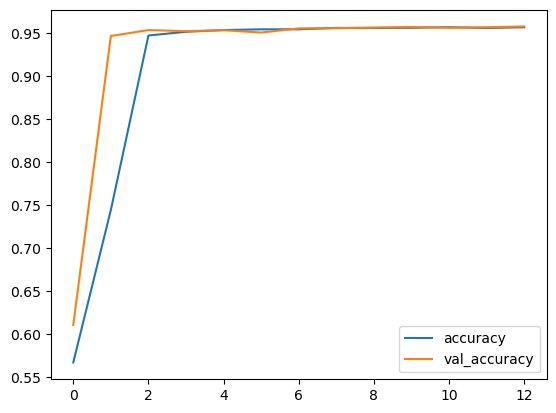

In [27]:
pd.DataFrame({'accuracy': history.history['accuracy'],
              'val_accuracy': history.history['val_accuracy']}).plot.line()

In [28]:
model.evaluate(ds[2])

173/173 [==============================] - 12s 67ms/step - loss: 0.1374 - accuracy: 0.9530


[0.13737589120864868, 0.9530116319656372]

# Model optimization

In [11]:
def build_model(hp, max_convols=3):
    inputs = keras.Input(shape=(None, None, 3))
    x = keras.layers.Rescaling(scale=1.0 / 255)(inputs)
    init_filters = hp.Choice('init_filters', [4, 8, 16]) #No. filters in the 1st convol layer
    kernel_size = hp.Int('kernel_size', 3, 4, 1)
    num_chan = init_filters
    x = keras.layers.Conv2D(
        filters=init_filters,
        kernel_size=kernel_size,
        strides=(1, 1),
        padding="valid",
        activation='relu')(x)
    for i in range(hp.Int("num_convols", 0, max_convols)):
        # i is the number of convlutions with MaxPooling
        # There is another convolution with GlobalMaxPooling
        if i != 0:
            x = keras.layers.MaxPooling2D(
                pool_size=(2, 2), 
                strides=None, 
                padding="valid")(x)
            num_chan = init_filters * (i + 1)
            x = keras.layers.Conv2D(
                filters=num_chan,
                kernel_size=kernel_size,
                strides=(1, 1),
                padding="valid",
                activation='relu')(x)
    x = keras.layers.GlobalMaxPooling2D()(x)
    x = keras.layers.Flatten()(x)
    for j in range(hp.Int('num_dense', 1, 2, 1)):
        x = keras.layers.Dense(units=num_chan, #Number of channels in the last layer
                               activation="relu",
                              kernel_regularizer=None)(x)
        x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='Adam',
         loss='binary_crossentropy',
         metrics=['accuracy'])    
    return model

In [12]:
build_model(keras_tuner.HyperParameters())

In [13]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=15,
    num_initial_points=2,
    alpha=0.0001,
    beta=2.6,
    seed=8)

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
init_filters (Choice)
{'default': 4, 'conditions': [], 'values': [4, 8, 16], 'ordered': True}
kernel_size (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 4, 'step': 1, 'sampling': None}
num_convols (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 3, 'step': 1, 'sampling': None}
num_dense (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': None}


In [15]:
tuner.search(ds[0], epochs=10, validation_data=ds[1])

Trial 9 Complete [00h 53m 05s]
val_accuracy: 0.9622573256492615

Best val_accuracy So Far: 0.9633460640907288
Total elapsed time: 05h 26m 33s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
16                |16                |init_filters
3                 |4                 |kernel_size
3                 |3                 |num_convols
2                 |1                 |num_dense

Epoch 1/10
325/517 [=================>............] - ETA: 1:18 - loss: 0.4975 - accuracy: 0.6965

KeyboardInterrupt: 